<a href="https://colab.research.google.com/github/andresdp/things-blockchain/blob/main/pinta1_geers2022_simblockchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
### **Merkle Tree**

La primera parte es la implementación de un Arbol de Merkle para poder registrar en cada bloque (de la blockchain) un grupo de transacciones. Cada transaccion se ve como un registro de tipo JSON.

La implementación del Arbol de Merkle se basó en la biblioteca [anytree](https://github.com/c0fec0de/anytree), para facilitar temás comunes de manejo y visualización de un árbol binario. *Nota*: No se consideró el balanceo del árbol.

In [1]:
!pip install anytree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from anytree import NodeMixin, RenderTree
from anytree.exporter import DotExporter
from IPython.display import Image
from hashlib import sha256


# The main class for our Merkle Tree, which inherits from a base class (NodeMixin) from the anytree library
class MerkleTree(NodeMixin):

  # Constructor. The 'name' parameter refers to the contents of the node.
  # In our case, the content is the hash (of the transactions) of the node
  def __init__(self, name, parent=None, children=None):
    self.value = name
    if self.value is not None:
      self.name = MerkleTree._hash(self.value)
    else:
      self.name = None
    self.parent = parent
    if children:
      self.children = children
  
  # Build a binary tree with the (whole) list of transactions for a block
  def build(self, transactions):
      nodes = []
      self.transactions = []
      for tx in transactions:
        n = MerkleTree(tx)
        nodes.append(n)
    
      while len(nodes) > 1:
        new_level = []
        for i in range(0,len(nodes),2):
            node1 = nodes[i]
            if i+1 < len(nodes):
                node2 = nodes[i+1]
            else:
                new_level.append(nodes[i])
                break
            # Each (internal) node computes a has being equal to the sum of the hashes of its children
            fake_value = node1.name + node2.name
            parent = MerkleTree(fake_value, children=[node1, node2])
            new_level.append(parent)
        nodes = new_level 
    
      return nodes[0] # The root of the tree is returned
  
  # Utility function (class method) to compute a SHA256 of any input
  def _hash(input):
    return sha256(input.encode('utf-8')).hexdigest()

  # Access to the root hash (content of root node)
  def get_root_hash(self):
      return self.name

  # Utility function (class method) used for pretty printing of the tree
  def _nodenamefunc(node):
      if node.is_leaf:
        return "tx: " + node.value + "\n" + node.name 
      else:
        return node.name 

  # Utility function (class method) used for pretty printing of the tree
  def _nodeattrfunc(node):
      if node.is_leaf:
        return "shape=box" 
      else:
        return "shape=ellipse" 
  
  # It returns the leaves of the tree
  # If 'hashes' is True the transaction hashes are return. 
  # Otherwise, the real transactions are returned
  def get_transactions(self, hashes=True):
      if hashes:
        return ([node.name for node in self.leaves])
      else:
        return ([node.value for node in self.leaves])

  # It prints the tree to console (both hashes and transactions)
  def print(self):
      for pre, _, node in RenderTree(self):
        if node.is_leaf:
          print(pre, node.name, "(tx:", node.value,")")
        else:
          print(pre, node.name)
  
  # It renders the tree in a graphical format (both hashes and transactions)
  def show(self, img='mt.png'):
      de = DotExporter(self, nodeattrfunc=MerkleTree._nodeattrfunc,
              nodenamefunc=MerkleTree._nodenamefunc).to_picture(img)
      return Image(img)

---

In [3]:
# Test: Creation of a tree with 3 transactions
mt = MerkleTree(None)
mt = mt.build(['aa', 'bb', 'cc'])
mt.print()

 603228d3f0f74f6679ecc0e928a47ca7d486954d448bcfd7e156f3221095e971
├──  857b3347845d4297a11b88ed6e315e94773004f61ed1b027c583a5186e3579ca
│   ├──  961b6dd3ede3cb8ecbaacbd68de040cd78eb2ed5889130cceb4c49268ea4d506 (tx: aa )
│   └──  3b64db95cb55c763391c707108489ae18b4112d783300de38e033b4c98c3deaf (tx: bb )
└──  355b1bbfc96725cdce8f4a2708fda310a80e6d13315aec4e5eed2a75fe8032ce (tx: cc )


In [4]:
# Test: Printing the hashes of the transactions (leaves)
# If parameter 'hashes" is False, then the real values of the transactions are printed
mt.get_transactions(hashes=True)

['961b6dd3ede3cb8ecbaacbd68de040cd78eb2ed5889130cceb4c49268ea4d506',
 '3b64db95cb55c763391c707108489ae18b4112d783300de38e033b4c98c3deaf',
 '355b1bbfc96725cdce8f4a2708fda310a80e6d13315aec4e5eed2a75fe8032ce']

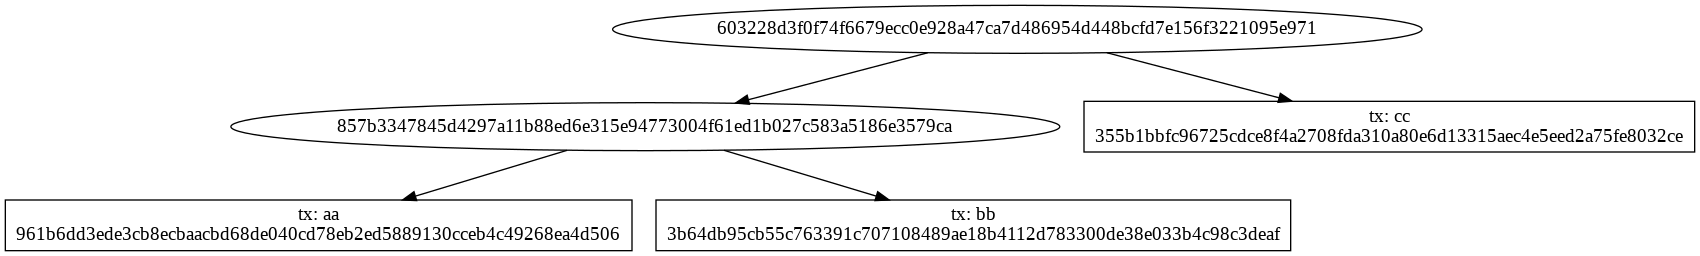

In [5]:
# Test: A graphical representation of the tree
mt.show()

---
### **Blockchain (simulation)**

La segunda parte es la implementación de la blockchain en si, que integra: el árbol de Merkle, la PoW, y la estructura de bloques y transacciones. Se realizaron las siguientes suposiciones (simplificaciones):
*  Existe un único minero (1 nodo full), al cuál el sistema le paga por cada bloque de transacciones que registra. No hay validación (por parte de otros nodos) de las transacciones de un nuevo bloque.
*  No se manejan claves criptográficas para las wallets (publica, privada, etc.).
*  Cada transacción tiene una única entrada y una única salida. No se consideró el fee de transacción para el minero.
*  Las transacciones que arriban se dejan "pendientes" (mempool), hasta que se completa la cantidad requerida por un bloque, y recién ahí se registran.
*  Las transacciones pueden fallar si son incorrectas, o involucran wallets inexistentes, o bien no hay saldo para realizar la transaccion.
*  Cada bloque posee internamente un arbol de Merkle que codifica sus transacciones.

In [6]:
from random import randint
from hashlib import sha256
from datetime import datetime
from timeit import default_timer as timer
from tqdm.notebook import tqdm
import random
import json


# La clase principal que implementa la blockchain (estilo Bitcoin)
class Blockchain:

  # Constructor
  def __init__(self, name, difficulty=2, tx_per_block=2, initial_money=50):
    self.name = name
    self.difficulty = difficulty # default value for proof of work
    self.transactions_per_block = tx_per_block # default value for transactions per block
    self.reward_money = initial_money # default value to issue by the system (to miners)

    # The hashes of the blocks are kept separate from the blocks themselves
    self.hashed_blocks = []
    self.mempool = [] # Transactions not committed yet to blocks
    self.blocks = [] # The list of blocks (without their hashes)

    # A list of the valid wallets
    self.wallets = []

    # Initialization of the list with block 0 (genesis)
    self._add_genesis_block()


  # TODO: It returns the current balance of a wallet up to a given block
  # The balance is reconstructed based on previous transactions in the blocks
  # Parameter 'transactions' might contain pending transactions (yet not committed to blocks)
  # that need to be considered in the reconstruction process
  def get_state(self, wallet, nblock, transactions=[]):    
    pass


  # Utility function to create a transaction record (as a dictionary)
  # The dictionary includes: source and target wallets, and ammount of the transaction
  # The parameters 'source' and 'target' should refer to existing wallets in the blockchain
  def _create_transaction(self, source, target, amount):
    formatted_tx = dict()
    formatted_tx['source'] = source
    formatted_tx['target'] = target
    formatted_tx['amount'] = amount
      
    return formatted_tx
  

  # It effectively transfers an amount of money from a 'source' wallet to a 'target' wallet
  # It the source wallet doesn't have enough money, the transfer is not executed
  # Before executing the transaction, the state (balance) of both wallets should be reconstructed
  # from the history of the blocks
  # Parameter 'valid_transactions' might include transactions to be committed in the current block (which are not yet part of the chain)
  def _execute_money_transfer(self, source, target, amount, valid_transactions):
    # The return values are a pair indicating whether the transanction succeeded,
    # along with the transaction just created
    
    # Both wallets must exist in the blockchain
    if (source != 'system') and (source not in self.wallets):
      return False, None
    if target not in self.wallets:
      return False, None

    # Reconstruction of the balance of both wallets
    current_block = self.height()
    state_source_wallet = self.get_state(source, current_block, valid_transactions)
    state_target_wallet = self.get_state(target, current_block, valid_transactions)

    # The transfer operation itself (from system to miner)
    # Name 'system' is a special sender to issue money in the blockchain
    # If the source is 'system', the the target should be a miner that gets paid for committing a block
    if source == 'system': 
      tx = self._create_transaction(source, target, amount)
      #print(json.dumps(tx)
      return True, tx
    
    # The transfer operation itself (from any source to any target wallets) 
    # The source wallet should have enough balance for the withdrawal
    if state_source_wallet >= amount: 
      tx = self._create_transaction(source, target, amount)
      #print(json.dumps(tx)
      return True, tx
    else:
      return False, None


  # It parses the incoming transaction (as a string) and tries to execute it.
  # Parameter 'block_transactions' might include additional transactions to be commited in the current block
  # The return values are a pair indicating whether the transaction succeeded (to execute), 
  # along with the transaction itself - formatted as a JSON dictionary.
  def _execute_transaction(self, transaction, block_transactions=[]):
    list_args = transaction.split(' ')
    if 'sends' in list_args:
      # Parse the transaction and extract its arguments 
      source = list_args[0]
      target = list_args[4]
      amount = list_args[2][1:]
      # Execute the transaction
      ok, tx = self._execute_money_transfer(source, target, int(amount), valid_transactions=block_transactions)
      print("Executing transaction...", "wallet-"+source, "-->", "wallet-"+target, ":", "$",amount, "[", ok,"]")
      return ok, tx
    else:
      print("Unknown transaction:", transaction)
      return False, None


  # It creates a new wallet with an empty balance.
  # Note: if the wallet already exists, then its state is overriden to 0
  def add_wallet(self, user):
    if (user != 'system') and (user != 'miner'): # These are special wallets handled by the blockchain
      self.wallets.append(user)
      return True
    else:
      return False

  # Pretty printing of the state (balance) of the wallets
  # The wallets are reconstructed from the history of the blocks
  def print_wallets(self):
    print("blockchain:",self.name, "[wallets-from-blocks]")
    current_block = self.height()
    for k in self.wallets:
      state = self.get_state(k, current_block)
      print("\twallet-"+k,":", "$", state)  
      #pos_block, state = self.get_state(k, current_block)
      #print("\twallet-"+k,":", "$", state, "\t#"+str(pos_block))  

  
  # It shows pending transactions (which haven't been committed to the blockchain yet)
  # For printing committed transactions, method print_blocks() should be used instead
  def print_transactions(self):
    print("blockchain:",self.name, "[pending-transactions]")
    for tx in self.mempool:
      print("\t", tx)
  

  # Utility function (class method) to compute a SHA256 of any input
  def _hash(input):
    return sha256(input.encode('utf-8')).hexdigest()
  

  # Utility function to (re-)compute the hash of a given block
  def _hash_block(block):
    input = str(block['nonce']) + block['merkle_tree'].get_root_hash() + block['previous_hash']
    return Blockchain._hash(input)
  

  # TODO: It implements the PoW for a given seed
  # The difficulty level is taken as a configuration attribute from the class
  def proof_of_work(self, seed):
    pass
  

  # Utility function to create a block record (as a dictionary)
  # Note that the hash of the current block is returned and handled separately
  def _create_block(self, previous_hash, nonce, transactions):

      # The valid transactions are converted to JSON format and stored in the Merkle tree
      json_transactions = [json.dumps(t) for t in transactions]
      mt = MerkleTree(None)
      mt = mt.build(json_transactions)
      print("Merkle tree:")
      mt.print()

      block = dict()
      block['previous_hash'] = previous_hash
      block['nonce'] = nonce
      block['transactions'] = transactions
      block['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
      #block['hash'] = hash
      block['merkle_tree'] = mt

      # The tree hash (for the block transactions) and the previous hash 
      # (from the previous block) are both combined into a new hash for the block
      input = str(nonce) + mt.get_root_hash() + previous_hash
      current_hash = Blockchain._hash(input)

      return current_hash, block


  # This is called in the constructor to create block 0
  # It executes a number of initial transactions (within the block)
  # so as to issue money for the miner. In this way, the system
  # can get started and the miner could make transfers to other wallets
  def _add_genesis_block(self):
    if len(self.blocks) == 0:
      print("Configuring genesis block ...")
      self.wallets.append('miner') # A spacial wallet for the miner needs to be created
      
      # The first PoW of the miner to get rewarded
      initial_nonce = randint(0,1000)
      nonce = self.proof_of_work(str(initial_nonce))
      # This is an initial transaction (reward) to get the system started
      tx = "system sends $"+ str(self.reward_money) +" to miner" # reward
      valid_transactions = []
      for n in range (1, self.transactions_per_block+1):
        #print(tx)
        ok, formatted_tx = self._execute_transaction(tx, valid_transactions) 
        #print(ok, formatted_tx)
        if ok:
          valid_transactions.append(formatted_tx)
      
      # The transactions are ready (validated) to be committed to a block
      if len(valid_transactions) == 0:
        print("Warning: All transactions failed, no block was created!")
        return
      
      # Since this is block 0, an arbitrary previous_hash is created
      previous_hash = Blockchain._hash(str(randint(0,1000)))
      current_hash, new_block = self._create_block(previous_hash, nonce, valid_transactions)

      # The block is created and stored
      self.blocks.append(new_block)
      self.hashed_blocks.append(current_hash)
      return current_hash
    
    else:
      print("Warning: Genesis block already exists!")
      return None
  

  # This is the public method that clients should use to send transactions to the blockchain
  # Transactions are enqueued for blocks
  # If parameter 'try_block' is True, as soon as the number of pending transactions is equal
  # to the number of allowed transactions per block, a new block is added to the blockchain
  def submit_transaction(self, tx, try_block=True):
    if len(self.blocks) > 0:
      self.mempool.append(tx)
      print("Transaction stored and awaiting for block:",tx)

      if try_block:
        if len(self.mempool) >= self.transactions_per_block:
          # A batch of transactions is retrieved from the queue and submitted for a new block
          n_transactions = self.mempool[0:self.transactions_per_block]
          hash = self._add_block(n_transactions)
          return hash

    else:
      print("Error: Genesis block is not configured!")
    
    return None
  

  # It gets a batch of transactions and assembles them in a block
  def _add_block(self, n_transactions):
    if len(self.blocks) > 0:
      print("Configuring new block ... (",len(n_transactions),"transactions)")
      previous_proof = self.blocks[-1]['nonce'] # It takes the nonce of the previous block to make a new proof
      nonce = self.proof_of_work(str(previous_proof)) # The miner's PoW to be rewarded

      valid_transactions = []
      # The reward from the system to the miner for the PoW
      tx = "system sends $"+ str(self.reward_money) +" to miner"
      ok, formatted_tx = self._execute_transaction(tx, valid_transactions)
      if ok:
        valid_transactions.append(formatted_tx)

      # All the other transactions to be included in the block
      for tx in n_transactions:
          self.mempool.remove(tx)
          #print(tx)
          ok, formatted_tx = self._execute_transaction(tx, valid_transactions) 
          if ok:
            valid_transactions.append(formatted_tx)
      
      # The transactions are ready (validated) to be committed to a block
      if len(valid_transactions) == 0:
        print("Warning: All transactions failed, no block was created!")
        return
      
      # The block is linked to the hash of the last block in the chain
      previous_hash = self.hashed_blocks[-1]
      current_hash, new_block = self._create_block(previous_hash, nonce, valid_transactions)

      # The block is created and stored
      self.blocks.append(new_block)
      self.hashed_blocks.append(current_hash)
      return current_hash
    
    else:
      print("Error: Genesis block is not configured!")
      return None
  

  # Verifies if the current chain is valid. This means to ensure, for each block that the hash
  # to the previous block is Ok, and also that the proof-of-work has been done
  def verify_chain(self):
    print("Verifying current blockchain... [",len(self.blocks),"blocks]")
    previous_block_index = 0
    block_index = 1

    if len(self.blocks) <= 1:
      print("Warning: no blocks to verify!")
    
    header = '0'*self.difficulty
    while block_index < len(self.blocks):
      current_block = self.blocks[block_index]
      previous_block = self.blocks[previous_block_index]
      
      previous_hash = Blockchain._hash_block(previous_block)
      # First check (hashes)
      if current_block['previous_hash'] != previous_hash:
        print("Hashes don't match for blocks:", previous_block_index, '->', block_index)
        return False
      
      # Second check (proof-of-work)
      guess_hash = Blockchain._hash(str(previous_block['nonce']) + str(current_block['nonce']))
      #print("===", block_index, guess_hash)
      if guess_hash[:self.difficulty] != header:
        print("Proof of work is not valid:", guess_hash, previous_block_index, '->', block_index)
        return False

      previous_block_index += 1
      block_index += 1

    return True


  # Pretty printing of all the blocks and their contents
  def print_blocks(self, show_mt=False):
    print("blockchain:",self.name, "[blocks]")
    n = 0
    for b in self.blocks:
      print(" #"+str(n)+":", b)
      n += 1
      if show_mt:
        b['merkle_tree'].print()
  

  # The lenght of the chain of blocks
  def height(self):
    return len(self.blocks)


  # Access to a given block by position in the chain
  # It returns both the hash and contents of the block
  def get_block(self, pos):
    return self.hashed_blocks[pos], self.blocks[pos]

  
  # It forces to process all pending transactions and submit them to a single block
  def process_all_transactions(self):
    if len(self.blocks) > 0:
        hash = self._add_block(self.mempool)
        return hash
    else:
      print("Error: Genesis block is not configured!")
      return None


---

In [7]:
# Test: configuration of a simple (so far, empty) blockchain
# Genesis block is created, including 2 transactions from the system to the miner
myblockchain = Blockchain('test', difficulty=3)

# Pring status of blockchain
print()
myblockchain.print_wallets()
myblockchain.print_transactions()
myblockchain.print_blocks(show_mt=True)

myblockchain.verify_chain()

Configuring genesis block ...
Doing proof of work for: 929 ( difficulty: 3 )


0it [00:00, ?it/s]

   00028486fd4a2b14547c67eb70b9435bab7b803e6f324fc4f93200a5cc50b909
   elapsed time (secs): 0.0496937939997224
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Merkle tree:
 b3d4158e2cbf3317ee35d4dcb6f7dc88fcd6598907f9c2504711879b44ab8b2c
├──  c9de5283ff5cea731fe72e17902497dc4fbecd24f411656c1e63bad7d01b4e9b (tx: {"source": "system", "target": "miner", "amount": 50} )
└──  c9de5283ff5cea731fe72e17902497dc4fbecd24f411656c1e63bad7d01b4e9b (tx: {"source": "system", "target": "miner", "amount": 50} )

blockchain: test [wallets-from-blocks]
	wallet-miner : $ 100
blockchain: test [pending-transactions]
blockchain: test [blocks]
 #0: {'previous_hash': 'de5872c6bb4494cebd250152ce148cd6231654e4469229f2f993984b3950b422', 'nonce': 536.4359093999657, 'transactions': [{'source': 'system', 'target': 'miner', 'amount': 50}, {'source': 'system', 'target': 'miner', 'amount': 50}], 'timestamp': '2022-08-03 13:2

True

In [8]:
# Test: Creation of 3 users (wallets)
myblockchain.add_wallet('bob')
myblockchain.add_wallet('alice')
myblockchain.add_wallet('john')
myblockchain.print_wallets()

# List of predefined transactions
tx0 = 'miner sends $70 to bob'
tx1 = 'bob sends $30 to alice'
tx2 = 'bob receives $1000 to alice' # The transaction type is invalid and it should be rejected
tx3 = 'bob sends $1000 to alice' # The transaction amount exceeds exceeds bob's balance
tx4 = 'bob sends $10 to john'

# Submit tx0, which is stored and set as pending for the block 1
_ = myblockchain.submit_transaction(tx0)

myblockchain.verify_chain()

blockchain: test [wallets-from-blocks]
	wallet-miner : $ 100
	wallet-bob : $ 0
	wallet-alice : $ 0
	wallet-john : $ 0
Transaction stored and awaiting for block: miner sends $70 to bob
Verifying current blockchain... [ 1 blocks]


True

In [9]:
# Test: The remaining transactions are submitted for processing
# Note: some transactions will fail (see below)
myblockchain.submit_transaction(tx1)
myblockchain.submit_transaction(tx2) # The transaction type is invalid and it should be rejected
myblockchain.submit_transaction(tx3) # The transaction amount exceeds exceeds bob's balance
myblockchain.submit_transaction(tx4)

_ = myblockchain.process_all_transactions()

myblockchain.verify_chain()

Transaction stored and awaiting for block: bob sends $30 to alice
Configuring new block ... ( 2 transactions)
Doing proof of work for: 536.4359093999657 ( difficulty: 3 )


0it [00:00, ?it/s]

   0003095462c675f06f4b5be13957bcdb702b8f8f668d7f4c64749d6ceae0e0d8
   elapsed time (secs): 0.18301633500004755
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Executing transaction... wallet-miner --> wallet-bob : $ 70 [ True ]
Executing transaction... wallet-bob --> wallet-alice : $ 30 [ True ]
Merkle tree:
 63b28cbfa04a028c2b59b0c026b6ca654068eb3fc8f6f659277407c018c7b4e2
├──  3e379ecde6ae0387b97ff0154892e2753a91fb865c1548d9f935486e0317ed5f
│   ├──  c9de5283ff5cea731fe72e17902497dc4fbecd24f411656c1e63bad7d01b4e9b (tx: {"source": "system", "target": "miner", "amount": 50} )
│   └──  5e982bf684e49e525442d1765636999c021f1a4432512011573d0f750a748ebd (tx: {"source": "miner", "target": "bob", "amount": 70} )
└──  6158a246903a55f1b2280f325a54239d12591f2374617aa4f0a29c15cb4e1a6d (tx: {"source": "bob", "target": "alice", "amount": 30} )
Transaction stored and awaiting for block: bob receives $1000 to alice
Transaction stored and awaiting for block: bob sends $1000 to a

0it [00:00, ?it/s]

   000944eef84e458dcbbdab09ed6c9cb099ad78c8069cdd275eb73e8e2955438c
   elapsed time (secs): 0.07983373500019297
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Unknown transaction: bob receives $1000 to alice
Executing transaction... wallet-bob --> wallet-alice : $ 1000 [ False ]
Merkle tree:
 c9de5283ff5cea731fe72e17902497dc4fbecd24f411656c1e63bad7d01b4e9b (tx: {"source": "system", "target": "miner", "amount": 50} )
Transaction stored and awaiting for block: bob sends $10 to john
Configuring new block ... ( 1 transactions)
Doing proof of work for: 149.74785814382696 ( difficulty: 3 )


0it [00:00, ?it/s]

   000d8c927d37d1b4c048f2795f2c33de4ec14d36d16a5ccdd5d774fa77f454e3
   elapsed time (secs): 0.1082063809999454
Executing transaction... wallet-system --> wallet-miner : $ 50 [ True ]
Executing transaction... wallet-bob --> wallet-john : $ 10 [ True ]
Merkle tree:
 a830a76ddb17ad9c3394915223fc15a62e3dc84776f40915d20ae1aa9a00fa61
├──  c9de5283ff5cea731fe72e17902497dc4fbecd24f411656c1e63bad7d01b4e9b (tx: {"source": "system", "target": "miner", "amount": 50} )
└──  71e67fcfc7589e13dce677071d8e19cb4de05067e896ce5d5b9579d3cb38503d (tx: {"source": "bob", "target": "john", "amount": 10} )
Verifying current blockchain... [ 4 blocks]


True

In [10]:
# Pring status of blockchain (after processing the transactions)
myblockchain.print_wallets()
myblockchain.print_transactions()
myblockchain.print_blocks(show_mt=False)

myblockchain.verify_chain()

blockchain: test [wallets-from-blocks]
	wallet-miner : $ 180
	wallet-bob : $ 30
	wallet-alice : $ 30
	wallet-john : $ 10
blockchain: test [pending-transactions]
blockchain: test [blocks]
 #0: {'previous_hash': 'de5872c6bb4494cebd250152ce148cd6231654e4469229f2f993984b3950b422', 'nonce': 536.4359093999657, 'transactions': [{'source': 'system', 'target': 'miner', 'amount': 50}, {'source': 'system', 'target': 'miner', 'amount': 50}], 'timestamp': '2022-08-03 13:22:03', 'merkle_tree': <__main__.MerkleTree object at 0x7fa14b7bfe10>}
 #1: {'previous_hash': '071bf8610343900b643203685528d90cdc890bfb70891b6289d5ef6fd7e2224f', 'nonce': 13191.044385164096, 'transactions': [{'source': 'system', 'target': 'miner', 'amount': 50}, {'source': 'miner', 'target': 'bob', 'amount': 70}, {'source': 'bob', 'target': 'alice', 'amount': 30}], 'timestamp': '2022-08-03 13:22:04', 'merkle_tree': <__main__.MerkleTree object at 0x7fa14b75fa90>}
 #2: {'previous_hash': '872fb70f8d7d615c11e92348aca251b6984aa6ae14a6ed2

True

In [11]:
# Test: Let's inspect the contents of block 1
print("Height:", myblockchain.height())
hash1, block1 = myblockchain.get_block(1)
print(hash1)
block1

Height: 4
872fb70f8d7d615c11e92348aca251b6984aa6ae14a6ed2a9b2d9b8b9c815ef0


{'merkle_tree': <__main__.MerkleTree at 0x7fa14b75fa90>,
 'nonce': 13191.044385164096,
 'previous_hash': '071bf8610343900b643203685528d90cdc890bfb70891b6289d5ef6fd7e2224f',
 'timestamp': '2022-08-03 13:22:04',
 'transactions': [{'amount': 50, 'source': 'system', 'target': 'miner'},
  {'amount': 70, 'source': 'miner', 'target': 'bob'},
  {'amount': 30, 'source': 'bob', 'target': 'alice'}]}

 63b28cbfa04a028c2b59b0c026b6ca654068eb3fc8f6f659277407c018c7b4e2
├──  3e379ecde6ae0387b97ff0154892e2753a91fb865c1548d9f935486e0317ed5f
│   ├──  c9de5283ff5cea731fe72e17902497dc4fbecd24f411656c1e63bad7d01b4e9b (tx: {"source": "system", "target": "miner", "amount": 50} )
│   └──  5e982bf684e49e525442d1765636999c021f1a4432512011573d0f750a748ebd (tx: {"source": "miner", "target": "bob", "amount": 70} )
└──  6158a246903a55f1b2280f325a54239d12591f2374617aa4f0a29c15cb4e1a6d (tx: {"source": "bob", "target": "alice", "amount": 30} )


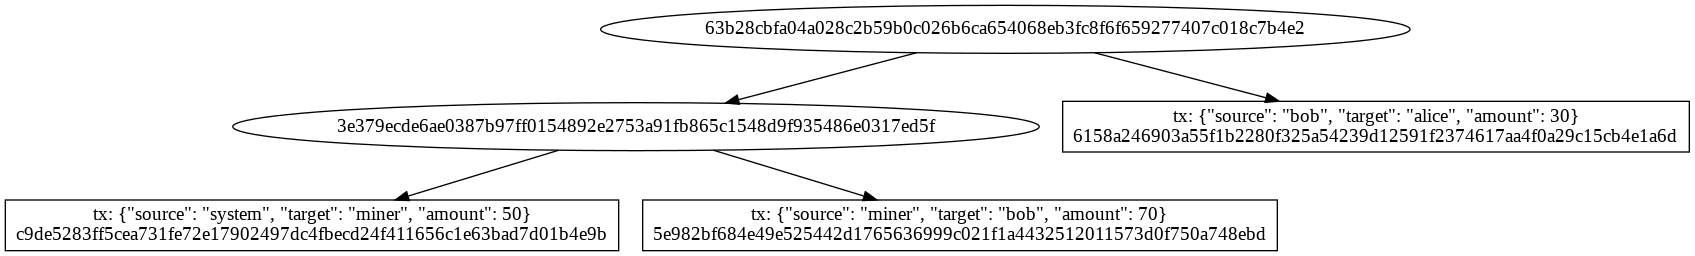

In [12]:
block1['merkle_tree'].print()
block1['merkle_tree'].show()

---